# Finding Shapes
Christopher Fichtlscherer, 29.05.2020, fichtlscherer@mailbox.org

In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt

## Create Circle Data

In [ ]:
def create_circle_array(x_size, y_size, center_x, center_y, thickness, radius):
    """creates a binary, two dim numpy array in which a circle has the
        value 1 all other values are 0"""

    x_mesh, y_mesh = np.mgrid[:x_size, :y_size]

    circle = (x_mesh - center_x) ** 2 + (y_mesh - center_y) ** 2

    c_array = np.logical_and(circle < (radius**2 + thickness), circle > (radius**2 - thickness)).astype(float)

    return c_array

In [ ]:
n = 500 # the number of arrays we want to create

split = 300 # till wich use the data for training
epos = 20

x_size, y_size = 100, 100 # size of the array
center_x, center_y = 50, 50 # center of the circle
delta_x, delta_y = 10, 10 # center will be random in [center_x - delta_x: center_x + delta_x]

thickness = 25 # thickness of the circle
radius = 20 # radius of the circle
delta_r = 5 # radius will be random in [radius - delta_r: radius + delta_r]

noise_level = 1

circles = np.zeros((n, x_size, y_size))
c_attributes = np.zeros((n, 3))

for i in tqdm(range(n)):
    
    cx = center_x + delta_x * (2 * (np.random.random()-0.5))
    cy = center_y + delta_y * (2 * (np.random.random()-0.5))
    r = radius + delta_r * (2 * (np.random.random()-0.5))

    attributes = np.array([cx, cy, r])
    c_array = create_circle_array(x_size, y_size, cx, cy, thickness, r)    

    circles[i] = c_array + noise_level * np.random.random((x_size, y_size))
    c_attributes[i] = attributes

In [ ]:
plt.imshow(circles[9])

In [ ]:
print(circles.shape)
print(c_attributes.shape)

circles_ex = np.expand_dims(circles, axis=3)

print(circles_ex.shape)

train_circles, test_circles = circles_ex[:split], circles_ex[split:]
train_attributes, test_attributes = c_attributes[:split], c_attributes[split:]

print(train_circles.shape)
print(train_attributes.shape)

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 25, input_shape=(x_size, y_size, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3)
])

In [ ]:
model.summary()

In [ ]:
model.compile(loss= "mean_squared_error" , optimizer="adam")

In [ ]:
model.fit(train_circles, train_attributes, epochs=epos)

In [ ]:
filters, biases = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

f0 = filters[:, :, :, 0]
f1 = filters[:, :, :, 1]
f2 = filters[:, :, :, 2]
f3 = filters[:, :, :, 3]
f4 = filters[:, :, :, 4]
f5 = filters[:, :, :, 5]

plt.subplot(231)
plt.imshow(f0[:, :, 0], cmap='gray')
plt.subplot(232)
plt.imshow(f1[:, :, 0], cmap='gray')
plt.subplot(233)
plt.imshow(f2[:, :, 0], cmap='gray')
plt.subplot(234)
plt.imshow(f3[:, :, 0], cmap='gray')
plt.subplot(235)
plt.imshow(f4[:, :, 0], cmap='gray')
plt.subplot(236)
plt.imshow(f5[:, :, 0], cmap='gray')

In [ ]:
model.evaluate(test_circles, test_attributes)

In [ ]:
predictions = model.predict(test_circles)

for i in range(30):
    print(max(abs(predictions[i]- test_attributes[i])))

***

### Plot a box around the Circle

In [ ]:
circle_number = 15

cx, cy, r = predictions[circle_number]

x_1 = int(cx - r)
x_2 = int(cx + r)

y_1 = int(cy - r)
y_2 = int(cy + r)

test_circle_2d = test_circles[circle_number,:,:,0]

w_image = test_circle_2d.copy()
w_image[:,y_1] = -1
w_image[:,y_2] = -1
w_image[x_1-1 : x_1] = -1
w_image[x_2-1 : x_2] = -1

plt.imshow(w_image)

## Create Rectangular Data

In [4]:
def create_rect_array(x_size, y_size, left, right, top, bottom, thickness):
    """creates a binary, two dim numpy array in which a circle has the
        value 1 all other values are 0"""

    rect = np.zeros((x_size, y_size))

    rect[left-thickness:right+thickness, bottom-thickness:top+thickness] = 1
    rect[left:right, bottom:top] = 0
    
    return rect

In [18]:
n = 500 # the number of arrays we want to create

split = 400 # till wich use the data for training
epos = 50

x_size, y_size = 100, 100 # size of the array
left, right = 30, 60 
delta_left, delta_right = 15, 15 

bottom, top = 30, 60 # center of the circle
delta_bottom, delta_top = 15, 15 

thickness = 3 

noise_level = 0.5

rectangles = np.zeros((n, x_size, y_size))
r_attributes = np.zeros((n, 4))

for i in tqdm(range(n)):
    
    l = int(left + delta_left * (2 * (np.random.random()-0.5)))
    r = int(right + delta_right * (2 * (np.random.random()-0.5)))
    
    t = int(top + delta_top * (2 * (np.random.random()-0.5)))
    b = int(bottom + delta_bottom * (2 * (np.random.random()-0.5)))
    
    
    attributes = np.array([l, r, t, b])
    rect = create_rect_array(x_size, y_size, l, r, t, b, thickness)

    rectangles[i] = rect + noise_level * np.random.random((x_size, y_size))
    r_attributes[i] = attributes

100%|██████████| 500/500 [00:00<00:00, 5056.14it/s]


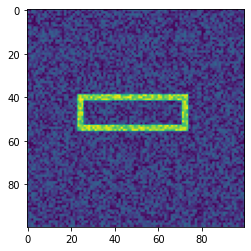

In [19]:
plt.imshow(rectangles[9])

In [20]:
rectangles_ex = np.expand_dims(rectangles, axis=3)

train_rectangles, test_rectangles = rectangles_ex[:split], rectangles_ex[split:]
train_attributes, test_attributes = r_attributes[:split], r_attributes[split:]

In [21]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 65, input_shape=(x_size, y_size, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4)
])

In [22]:
model.compile(loss= "mean_squared_error" , optimizer="adam")

In [23]:
model.fit(train_rectangles, train_attributes, epochs=epos)

Epoch 1/50
400/400 [==============================] - 10s 25ms/sample - loss: 1067.2273
Epoch 2/50
400/400 [==============================] - 9s 23ms/sample - loss: 182.4529
Epoch 3/50
400/400 [==============================] - 12s 29ms/sample - loss: 95.1242
Epoch 4/50
400/400 [==============================] - 9s 24ms/sample - loss: 74.7336
Epoch 5/50
400/400 [==============================] - 9s 23ms/sample - loss: 71.4093
Epoch 6/50
400/400 [==============================] - 9s 23ms/sample - loss: 65.4804
Epoch 7/50
400/400 [==============================] - 9s 23ms/sample - loss: 64.3310
Epoch 8/50
400/400 [==============================] - 9s 24ms/sample - loss: 60.3674
Epoch 9/50
400/400 [==============================] - 10s 24ms/sample - loss: 54.1748
Epoch 10/50
400/400 [==============================] - 9s 23ms/sample - loss: 51.5499
Epoch 11/50
400/400 [==============================] - 9s 24ms/sample - loss: 46.9232
Epoch 12/50
400/400 [==============================] - 9s

In [24]:
model.evaluate(test_rectangles, test_attributes)

100/100 [==============================] - 0s 5ms/sample - loss: 2.1682


2.1682204818725586

In [25]:
predictions = model.predict(test_rectangles)

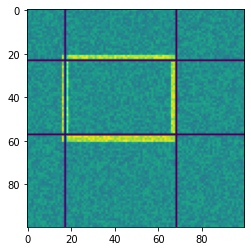

In [31]:
rect_number = 4

l, r, t, b = predictions[rect_number]

test_rect_2d = test_rectangles[rect_number,:,:,0]

w_image = test_rect_2d.copy()
w_image[:,int(b)] = -1
w_image[:,int(t)] = -1
w_image[int(l)-1 : int(l)] = -1
w_image[int(r)-1 : int(r)] = -1

plt.imshow(w_image)